In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_style("whitegrid")
# sns.set_theme()
matplotlib.rcParams['figure.figsize'] = [9.0/2, 5.0/2]

In [2]:
names = ["MSCI World", "MSCI EM", "Gold", "Bond 1-3y"]
tickers = ["EUNL.DE", "EUNM.DE", "8PSG.DE", "CBE3.L"]

## Prezzi ETF

In [5]:
dfs = []
for t in tickers:
    df = pd.read_csv(f"../dati/{t}.csv", index_col="Date")
    dfs.append(df)

In [ ]:
etfs = pd.concat(dfs, axis=1, sort=True)
etfs.columns = names
etfs = etfs.dropna(how="any")
etfs

,MSCI World,MSCI EM,Gold,Bond 1-3y
Date,,,,
2010-10-01,19.299999,21.930000,131.139893,102.010002
2010-11-01,19.610001,21.980000,134.917603,102.010002
2010-12-01,20.490000,23.240000,137.972305,102.010002
2011-01-01,21.670000,24.410000,138.233795,102.010002
2011-02-01,21.450001,22.719999,132.529602,101.529999
...,...,...,...,...
2025-03-01,106.769997,38.462002,265.239990,114.070000
2025-04-01,98.036003,37.672001,279.500000,114.199997
2025-05-01,93.360001,35.785000,281.100006,114.800003


In [ ]:
etfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 2010-10-01 to 2025-07-01
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MSCI World  178 non-null    float64
 1   MSCI EM     178 non-null    float64
 2   Gold        178 non-null    float64
 3   Bond 1-3y   178 non-null    float64
dtypes: float64(4)
memory usage: 7.0+ KB


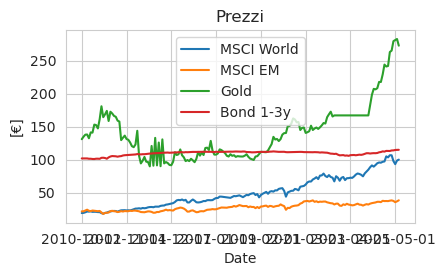

In [ ]:
etfs.plot(title="Prezzi", ylabel="[€]");

## Portafoglio base

In [ ]:
# capitale = 10000
anni = 5
pesi = np.array([0.5, 0.3, 0.05, 0.15])

In [ ]:
names

['MSCI World', 'MSCI EM', 'Gold', 'Bond 1-3y']

In [ ]:
ptf = (etfs.shift(-anni*12) / etfs) - 1
ptf = ptf.dropna(how="any")
ptf["RTOT"] = (ptf * pesi).sum(axis=1)
ptf.head()

,MSCI World,MSCI EM,Gold,Bond 1-3y,RTOT
Date,,,,,
2010-10-01,0.831606,-0.015048,-0.253088,0.093765,0.412699
2010-11-01,0.931157,0.045496,-0.247911,0.095089,0.481095
2010-12-01,0.944363,0.004733,-0.281450,0.096804,0.474050
2011-01-01,0.754961,-0.102827,-0.303065,0.096265,0.345919
2011-02-01,0.661072,-0.093750,-0.234511,0.101694,0.305940


<Axes: xlabel='Date'>

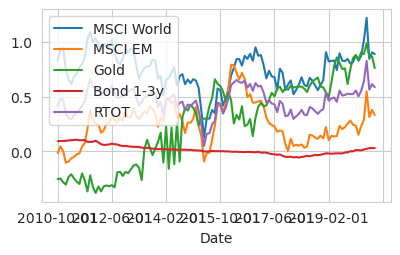

In [ ]:
ptf.plot()

### Statistiche

In [ ]:
ptf.RTOT.describe()

count    118.000000
mean       0.467834
std        0.117595
min        0.050638
25%        0.388588
50%        0.477572
75%        0.549727
max        0.828596
Name: RTOT, dtype: float64

VaR:

In [ ]:
var = ptf.RTOT.quantile(0.05)
var

0.2915770032044977

CVaR:

In [ ]:
cvar = ptf.RTOT[ptf.RTOT < var].mean()
cvar

0.19202073799795502

## Portafoglio al variare dell'allocazione

In [ ]:
def get_ptf(etfs, anni, pesi):
    ptf = (etfs.shift(-anni*12) / etfs) - 1
    ptf = ptf.dropna(how="any")
    ptf["RTOT"] = (ptf * pesi).sum(axis=1)
    return ptf

def ptf_stats(ptf):
    d = ptf.RTOT.describe()
    d["VaR"] = ptf.RTOT.quantile(0.05)
    d["CVaR"] = ptf.RTOT[ptf.RTOT < var].mean()
    return d

In [ ]:
ptf100Az = get_ptf(etfs, anni, [1.0, 0, 0, 0])
ptf_stats(ptf100Az)

count    118.000000
mean       0.747460
std        0.177071
min        0.126544
25%        0.649552
50%        0.767780
75%        0.872953
max        1.221125
VaR        0.413392
CVaR       0.126544
Name: RTOT, dtype: float64

In [ ]:
ptf0 = get_ptf(etfs, anni, pesi)
ptf_stats(ptf0)

count    118.000000
mean       0.467834
std        0.117595
min        0.050638
25%        0.388588
50%        0.477572
75%        0.549727
max        0.828596
VaR        0.291577
CVaR       0.192021
Name: RTOT, dtype: float64

## Ottimizzazione

In [ ]:
from scipy.optimize import minimize, LinearConstraint, shgo

In [ ]:
optFn = lambda w: -ptf_stats(get_ptf(etfs, anni, w)).CVaR
x0 = [0.0, 1.0, 0, 0]
x0 = [1.0, 0.0, 0, 0]
constraints = (
    LinearConstraint([1, 1, 1, 1], lb=1.0, ub=1.0),
)
bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
opts = {"disp": True}
sol = minimize(optFn, x0, bounds=bounds, constraints=constraints, 
    options=opts)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.262898053199645
            Iterations: 14
            Function evaluations: 142
            Gradient evaluations: 14


In [ ]:
sol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.262898053199645
       x: [ 5.615e-01  3.996e-16  4.383e-01  2.034e-04]
     nit: 14
     jac: [-5.986e-01 -2.199e-02  1.670e-01 -7.132e-02]
    nfev: 142
    njev: 14

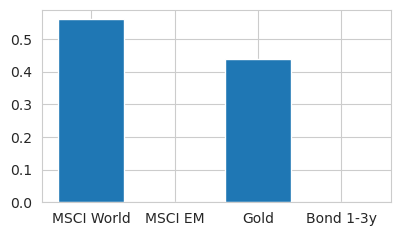

In [ ]:
plt.figure()
plt.bar(names, sol.x);

In [ ]:
sol = shgo(optFn, bounds, constraints=constraints, 
    options=opts)

In [ ]:
sol

 message: Optimization terminated successfully.
 success: True
     fun: -0.2629007240673604
    funl: [-2.629e-01]
       x: [ 5.615e-01  1.209e-16  4.385e-01  1.043e-08]
      xl: [[ 5.615e-01  1.209e-16  4.385e-01  1.043e-08]]
     nit: 1
    nfev: 437
   nlfev: 421
   nljev: 37
   nlhev: 0

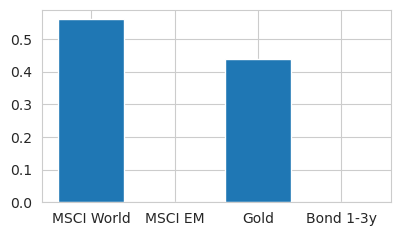

In [ ]:
plt.figure()
plt.bar(names, sol.x);

In [ ]:
pftOpt = get_ptf(etfs, anni, sol.x)
ptf_stats(pftOpt)

count    118.000000
mean       0.538426
std        0.174855
min        0.201688
25%        0.412234
50%        0.533154
75%        0.626572
max        1.119486
VaR        0.288963
CVaR       0.262901
Name: RTOT, dtype: float64

<Axes: >

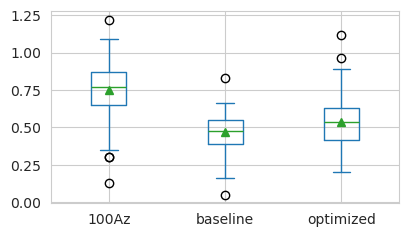

In [ ]:
summary = pd.DataFrame()
summary["100Az"] = ptf100Az.RTOT
summary["baseline"] = ptf0.RTOT
summary["optimized"] = pftOpt.RTOT
summary.plot(kind="box", showmeans=True)